In [425]:
import numpy as np
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
import skimage
import time

In [426]:
def read_images(image_path):
    img = cv2.imread(image_path)
    img  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)/255
    return img

### Scale Space by increasing Sigma

In [427]:
def  generate_scale_space(image, initial_sigma, constant_multiplier, iterations):
    current_sigma = initial_sigma
    height = image.shape[0]
    width = image.shape[1]
    scale_space = np.empty((height, width, iterations))
    sigma_values = []
    for i in range(0, iterations):
        sigma_values.append(current_sigma)
        LoG_response = ndimage.gaussian_laplace(image, current_sigma,mode="nearest")
        sigma_normalized_LoG =  np.square(current_sigma) * LoG_response
        scale_space[:,:,i] = np.square(sigma_normalized_LoG)
        current_sigma = math.ceil(constant_multiplier * current_sigma)

    return scale_space

### Scale Space by Downsizing Image


In [428]:
def  generate_constant_scale_space(image, initial_sigma, constant_multiplier, iterations):
    current_sigma = initial_sigma
    height = image.shape[0]
    width = image.shape[1]
    scale_space = np.empty((height, width, iterations))
    factor = 1
    sigma_values = []
    for i in range(0, iterations):
        sigma_values.append(current_sigma)
        LoG_response = ndimage.gaussian_laplace(skimage.transform.resize(image, (image.shape[0]//factor,  image.shape[1]//factor), anti_aliasing=True), current_sigma,mode="nearest")
        sigma_normalized_LoG =  np.square(current_sigma) * LoG_response
        scale_space[:,:,i] = np.square(skimage.transform.resize(sigma_normalized_LoG, (image.shape[0],  image.shape[1])))
        factor = factor * constant_multiplier
    return scale_space

#### Suppress across 2D slices and 3D scale space

In [429]:
def non_maximum_suppression(scale_space, window_size):
    suppressed_space = ndimage.rank_filter(scale_space,rank=-1, footprint=np.ones((window_size,window_size,1)))
    suppressed_space = scale_space * (np.array(suppressed_space == scale_space).astype(int))
    return suppressed_space

def non_maximum_sup_scale_space(scale_space):
    suppressed_space = np.empty((scale_space.shape[0],scale_space.shape[1],scale_space.shape[2]))
    for i in range(scale_space.shape[2]):
         y = ndimage.rank_filter(scale_space[:,:,max(0,i-2):min(scale_space.shape[2],i+3)], rank=-1, size=(13,13,min(scale_space.shape[2],i+3)-max(0,i-2)+1))
         suppressed_space[:,:,i] = y[:,:,-1]

    new_suppressed_scale_space = scale_space *  (np.array(suppressed_space == scale_space).astype(int))

    return new_suppressed_scale_space

#### Apply scale space blob detection logic

In [430]:
def apply_scale_space_logic(img, initial_sigma, constant_scale_factor, iterations):
    scale_space = generate_scale_space(img , initial_sigma, constant_scale_factor, 12 )
    suppressed_responses = non_maximum_suppression(scale_space, suppress_window)
    suppressed_sp = non_maximum_sup_scale_space(suppressed_responses)
    return suppressed_sp

def apply_constant_scale_space_logic(img, initial_sigma, constant_scale_factor, iterations):
    scale_space = generate_constant_scale_space(img , initial_sigma, constant_scale_factor, 12 )
    suppressed_responses = non_maximum_suppression(scale_space, suppress_window)
    suppressed_sp = non_maximum_sup_scale_space(suppressed_responses)
    return suppressed_sp

In [431]:
def get_coordinates(img_space, threshold):
    coordinates = np.where(img_space > threshold)
    return coordinates[0],coordinates[1],coordinates[2]

In [432]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, (pow(constant_scale_factor,rad) * initial_sigma)):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

In [453]:
def log_details(image_name, initial_sigma, constant_scale_factor, iterations, method_type, threshold,time):

    if method_type == 1:
        print("***Inefficient Method******\nImage name:", image_name)
        print("Scale Factor:",constant_scale_factor)
    else:
        print("***Efficient Method******\nImage name:", image_name)
    print("Time taken:", time)
    print("Initial Sigma:",initial_sigma )
    print("Iterations:",iterations )
    print("Threshold:",threshold )


In [454]:
constant_scale_factor = 1.25
initial_sigma = 2
suppress_window = 5
threshold = .0109
iterations = 10
#

***Inefficient Method******
Image name: butterfly.jpg
Scale Factor: 1.25
Time taken: 0.6004369258880615
Initial Sigma: 2
Iterations: 10
Threshold: 0.0109


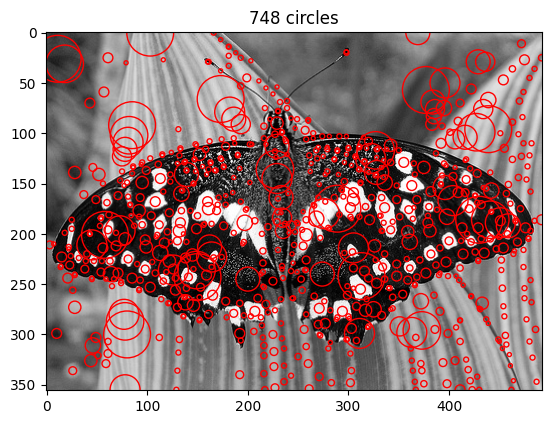

In [455]:
image_path = 'butterfly.jpg'
img = read_images(image_path)

start = time.time()
scale_space = apply_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

log_details(image_path, initial_sigma, constant_scale_factor, iterations, 1, threshold, end-start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)

***Efficient Method******
Image name: sunflowers.jpg
Time taken: 0.20669198036193848
Initial Sigma: 2
Iterations: 10
Threshold: 0.005


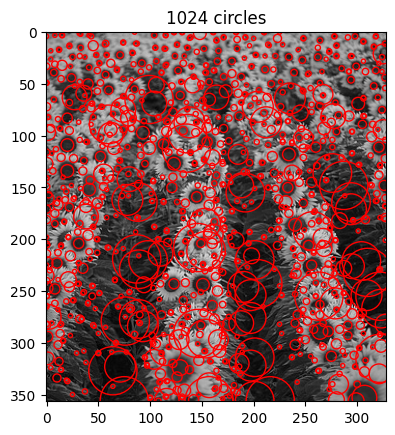

In [459]:
start = time.time()
scale_space = apply_constant_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

log_details(image_path, initial_sigma, constant_scale_factor, iterations, 2, threshold, end-start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)

***Inefficient Method******
Image name: fishes.jpg
Scale Factor: 1.25
Time taken: 0.5611779689788818
Initial Sigma: 2
Iterations: 10
Threshold: 0.006


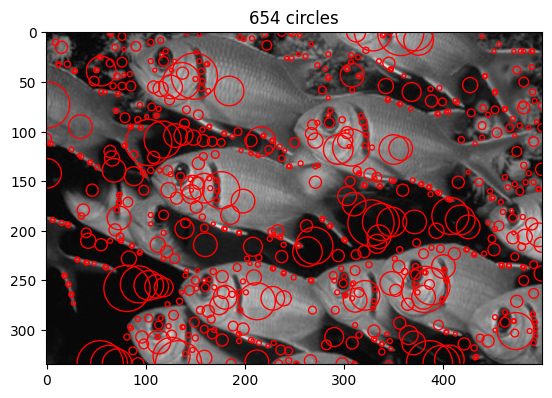

In [456]:
image_path = 'fishes.jpg'
img = read_images(image_path)
threshold = 0.006
start = time.time()
scale_space = apply_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

log_details(image_path, initial_sigma, constant_scale_factor, iterations, 1, threshold, end-start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)

***Inefficient Method******
Image name: sunflowers.jpg
Scale Factor: 1.25
Time taken: 0.21101808547973633
Initial Sigma: 2
Iterations: 10
Threshold: 0.005


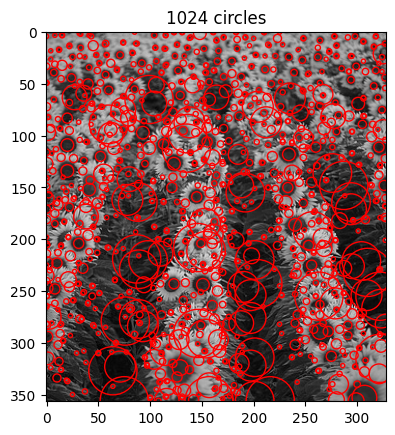

In [460]:
start = time.time()
scale_space = apply_constant_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

log_details(image_path, initial_sigma, constant_scale_factor, iterations, 1, threshold, end-start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)

***Inefficient Method******
Image name: einstein.jpg
Scale Factor: 1.25
Time taken: 1.0828490257263184
Initial Sigma: 2
Iterations: 10
Threshold: 0.005


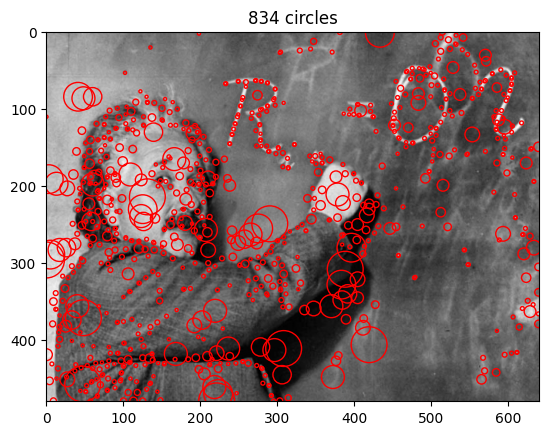

In [457]:
image_path = 'einstein.jpg'
img = read_images(image_path)
threshold = 0.005
start = time.time()
scale_space = apply_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

log_details(image_path, initial_sigma, constant_scale_factor, iterations, 1, threshold, end-start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)

***Inefficient Method******
Image name: sunflowers.jpg
Scale Factor: 1.25
Time taken: 0.2072310447692871
Initial Sigma: 2
Iterations: 10
Threshold: 0.005


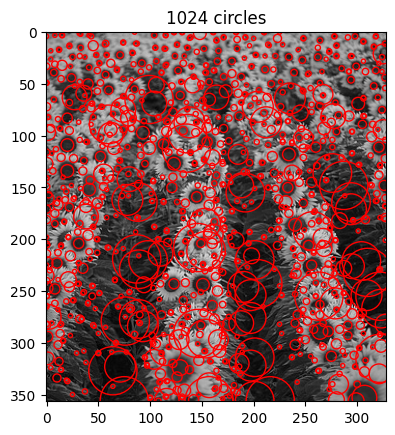

In [461]:
start = time.time()
scale_space = apply_constant_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

log_details(image_path, initial_sigma, constant_scale_factor, iterations, 1, threshold, end-start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)

***Inefficient Method******
Image name: sunflowers.jpg
Scale Factor: 1.25
Time taken: 0.373427152633667
Initial Sigma: 2
Iterations: 10
Threshold: 0.005


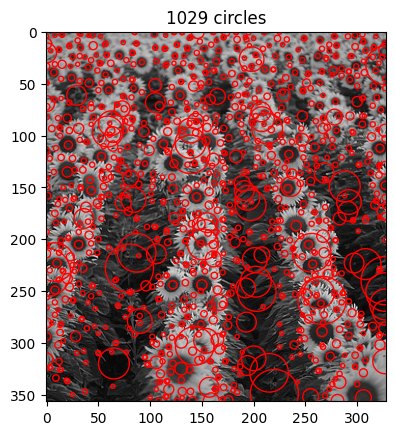

In [458]:
image_path = 'sunflowers.jpg'
img = read_images(image_path)
threshold = 0.005
start = time.time()
scale_space = apply_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

log_details(image_path, initial_sigma, constant_scale_factor, iterations, 1, threshold, end-start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)

***Inefficient Method******
Image name: sunflowers.jpg
Scale Factor: 1.25
Time taken: 0.2048628330230713
Initial Sigma: 2
Iterations: 10
Threshold: 0.005


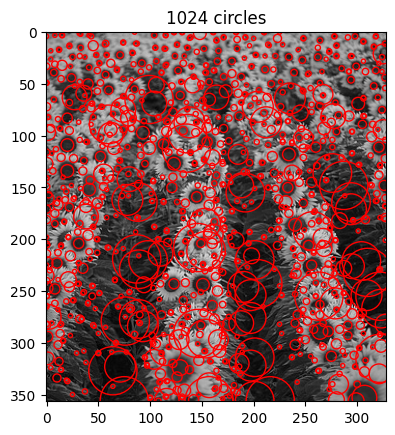

In [462]:
start = time.time()
scale_space = apply_constant_scale_space_logic(img, initial_sigma, constant_scale_factor,iterations)
end = time.time()

log_details(image_path, initial_sigma, constant_scale_factor, iterations, 1, threshold, end-start)
y, x, rad = get_coordinates(scale_space, threshold)
show_all_circles(img,x, y, rad)